In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q kaggle
!mkdir ~/.kaggle

In [3]:
! cp "/content/drive/MyDrive/Colab Notebooks/Thesis/kaggle.json"  ~/.kaggle

In [4]:
!kaggle datasets download -d jiayuanchengala/aid-scene-classification-datasets

 99% 2.43G/2.45G [00:36<00:00, 153MB/s]
100% 2.45G/2.45G [00:36<00:00, 72.2MB/s]


In [5]:
! cp "/content/aid-scene-classification-datasets.zip" "/content/drive/MyDrive/Colab Notebooks/Thesis"

In [6]:
# ! unzip -q "/content/drive/MyDrive/Colab Notebooks/Thesis/eurosat-dataset.zip"
# ! unzip -q "/content/drive/MyDrive/Colab Notebooks/Thesis/landuse-scene-classification.zip"
# ! unzip -q "/content/drive/MyDrive/Colab Notebooks/Thesis/NWPU-RESISC45.zip"
# ! unzip -q "/content/drive/MyDrive/Colab Notebooks/Thesis/PatternNet.zip"
! unzip -q "/content/drive/MyDrive/Colab Notebooks/Thesis/aid-scene-classification-datasets.zip"

In [7]:
datasets_dir =  "/content/AID"

In [8]:
IMG_SIZE = 128
BATCH_SIZE = 32
epochs = 20

In [9]:
import tensorflow as tf
tf.random.set_seed(42)

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = datasets_dir,
    image_size = (IMG_SIZE, IMG_SIZE),
    label_mode = 'categorical',
    color_mode="rgb",
    batch_size = BATCH_SIZE,
    seed=42,
    shuffle = True,
    validation_split=0.2,
    subset="training"

).prefetch(buffer_size=tf.data.AUTOTUNE)


test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory = datasets_dir,
    image_size =  (IMG_SIZE, IMG_SIZE),
    label_mode = 'categorical',
    color_mode="rgb",
    batch_size = BATCH_SIZE,
    seed=42,
    shuffle = True,
    validation_split=0.2,
    subset="validation"

)
class_names = test_dataset.class_names
test_data = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
# test_data = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
class_names


Found 10000 files belonging to 30 classes.
Using 8000 files for training.
Found 10000 files belonging to 30 classes.
Using 2000 files for validation.


['Airport',
 'BareLand',
 'BaseballField',
 'Beach',
 'Bridge',
 'Center',
 'Church',
 'Commercial',
 'DenseResidential',
 'Desert',
 'Farmland',
 'Forest',
 'Industrial',
 'Meadow',
 'MediumResidential',
 'Mountain',
 'Park',
 'Parking',
 'Playground',
 'Pond',
 'Port',
 'RailwayStation',
 'Resort',
 'River',
 'School',
 'SparseResidential',
 'Square',
 'Stadium',
 'StorageTanks',
 'Viaduct']

In [10]:
from sklearn.decomposition import PCA
import numpy as np

def compress_image(img_array, k):
    # Initialize an array for the compressed image.
    compressed_img_array = np.zeros_like(img_array)
    # Perform PCA on each color channel.
    for i in range(img_array.shape[-1]):
        pca = PCA(k)
        # Reshape the color channel to 2D array and apply PCA.
        reshaped = np.reshape(img_array[..., i], (-1, img_array.shape[2]))
        transformed = pca.fit_transform(reshaped)
        # Reconstruct the compressed image from the transformed matrix.
        inverse_transformed = pca.inverse_transform(transformed)
        # Reshape the inverse transformed matrix to original shape.
        compressed_img_array[..., i] = np.reshape(inverse_transformed, img_array[..., i].shape)
    return compressed_img_array



In [11]:
# Compress the images in the training and testing datasets.
k = 2  # Number of principal components to keep.
for img, label in train_data:
    img = compress_image(img.numpy(), k)
for img, label in test_data:
    img = compress_image(img.numpy(), k)

In [12]:
import tensorflow as tf

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal",input_shape=(IMG_SIZE, IMG_SIZE, 3)),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
  tf.keras.layers.experimental.preprocessing.RandomWidth(0.2)
], name ="data_augmentation")

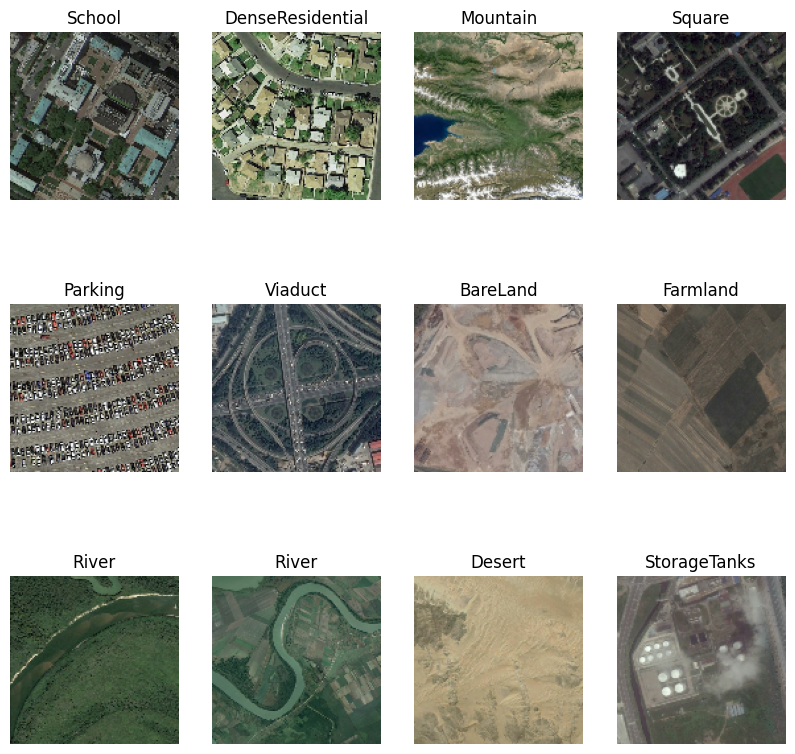

In [13]:
import matplotlib.pyplot as plt
import numpy as np


plt.figure(figsize=(10,10))

for image_batch,label_batch in train_data.take(1):
    for i in range(0,12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        plt.title(class_names[np.argmax(label_batch[i])])
        plt.axis("off")

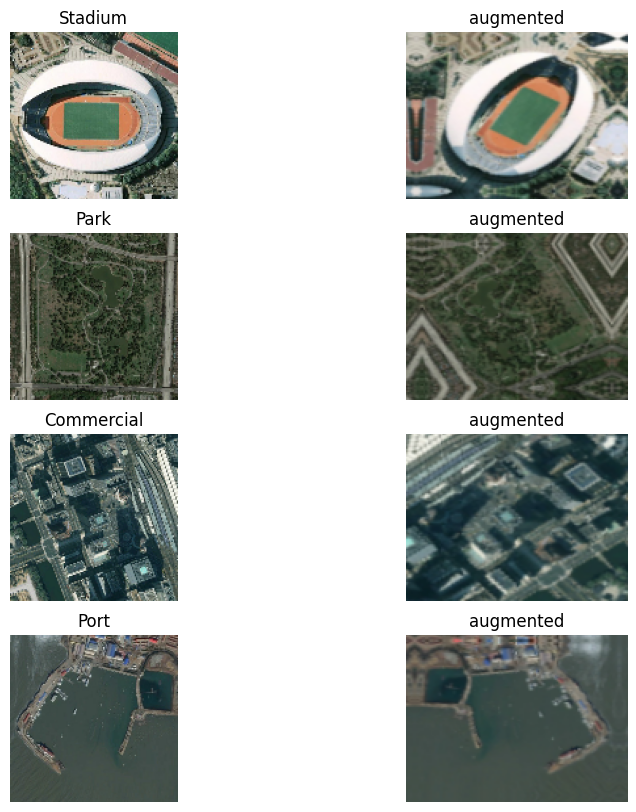

In [14]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in train_data.take(1):
    augmented_image_batch = data_augmentation(image_batch)
    image_plt_len = len(image_batch) if len(image_batch) < 4 else 4
    for i in range(0, image_plt_len):
        plt.subplot(image_plt_len,2,2*i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        plt.title(class_names[np.argmax(label_batch[i])])
        plt.axis("off")
        plt.subplot(image_plt_len,2,2*i+2)
        img = augmented_image_batch[i]
        img = np.array(img, dtype=np.int32)
        plt.imshow(img)
        plt.title(f"augmented")
        plt.axis("off")

94765736/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 data_augmentation (Sequent  (None, None, None, 3)        0         ['input_layer[0][0]']         
 ial)                                                                                             
                                                                                                  
 efficientnetb0 (Functional  (None, None, None, 1280)     4049571   ['data_augmentation[0][0]']   
 )                                                                                                
                             

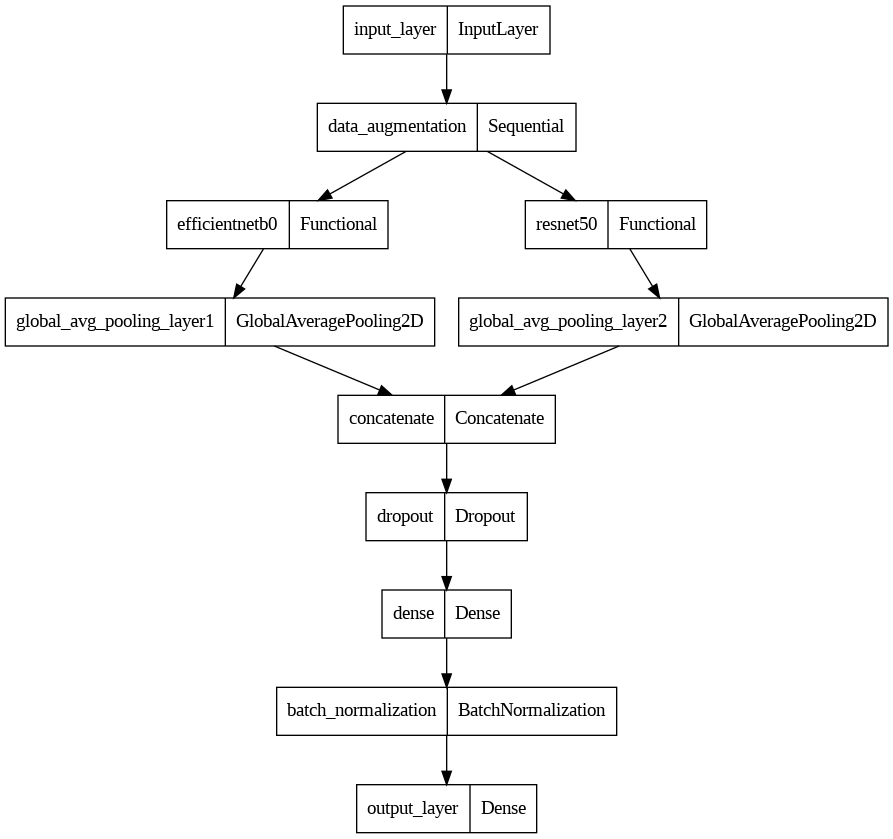

In [15]:
import tensorflow as tf

# Setup the base models and freeze their layers (this will extract features)
base_model1 = tf.keras.applications.EfficientNetB0(include_top=False)
base_model2 = tf.keras.applications.ResNet50(include_top=False)

base_model1.trainable = True  # Enable fine-tuning
base_model2.trainable = True  # Enable fine-tuning

# Fine-tune only the last N layers
fine_tune_at = 10
for layer in base_model1.layers[:-fine_tune_at]:
    layer.trainable = False

fine_tune_at = 4
for layer in base_model2.layers[:-fine_tune_at]:
    layer.trainable = False

# Setup model architecture with trainable top layers
inputs = tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='input_layer')
x = data_augmentation(inputs)
x1 = base_model1(x, training=False)
x2 = base_model2(x, training=False)
x1 = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pooling_layer1')(x1)
x2 = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pooling_layer2')(x2)
x = tf.keras.layers.concatenate([x1, x2])


x = tf.keras.layers.Dropout(0.4)(x)  # Adjust dropout rate
x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)  # Add dense layer with L2 regularization
x = tf.keras.layers.BatchNormalization()(x)  # Add batch normalization
outputs = tf.keras.layers.Dense(len(class_names), activation='softmax', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Adjust the learning rate
    metrics=['accuracy']
)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

# Learning rate schedule callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

model.summary()
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    dpi=96,
)


In [16]:
# Train the model with the learning rate schedule
history = model.fit(
    train_data,
    epochs=epochs,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
250/250 [==============================] - 195s 687ms/step - loss: 6.1000 - accuracy: 0.5405 - val_loss: 4.8234 - val_accuracy: 0.7690 - lr: 1.0000e-04
Epoch 2/20
250/250 [==============================] - 93s 369ms/step - loss: 4.4563 - accuracy: 0.7793 - val_loss: 3.9700 - val_accuracy: 0.8365 - lr: 1.0000e-04
Epoch 3/20
250/250 [==============================] - 78s 305ms/step - loss: 3.6417 - accuracy: 0.8379 - val_loss: 3.3530 - val_accuracy: 0.8435 - lr: 1.0000e-04
Epoch 4/20
250/250 [==============================] - 66s 258ms/step - loss: 3.0426 - accuracy: 0.8550 - val_loss: 2.8735 - val_accuracy: 0.8470 - lr: 1.0000e-04
Epoch 5/20
250/250 [==============================] - 62s 242ms/step - loss: 2.5670 - accuracy: 0.8702 - val_loss: 2.4546 - val_accuracy: 0.8530 - lr: 1.0000e-04
Epoch 6/20
250/250 [==============================] - 60s 232ms/step - loss: 2.1624 - accuracy: 0.8913 - val_loss: 2.1334 - val_accuracy: 0.8595 - lr: 1.0000e-04
Epoch 7/20
250/250 [=======

In [17]:
# Evaluate the model on both training and testing sets
model.evaluate(train_data), model.evaluate(test_data)

63/63 [==============================] - 10s 129ms/step - loss: 1.2706 - accuracy: 0.8820


([1.1303198337554932, 0.9153749942779541],
 [1.2706326246261597, 0.8820000290870667])

In [18]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.figure(figsize=(12,6))
  # Plot loss
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

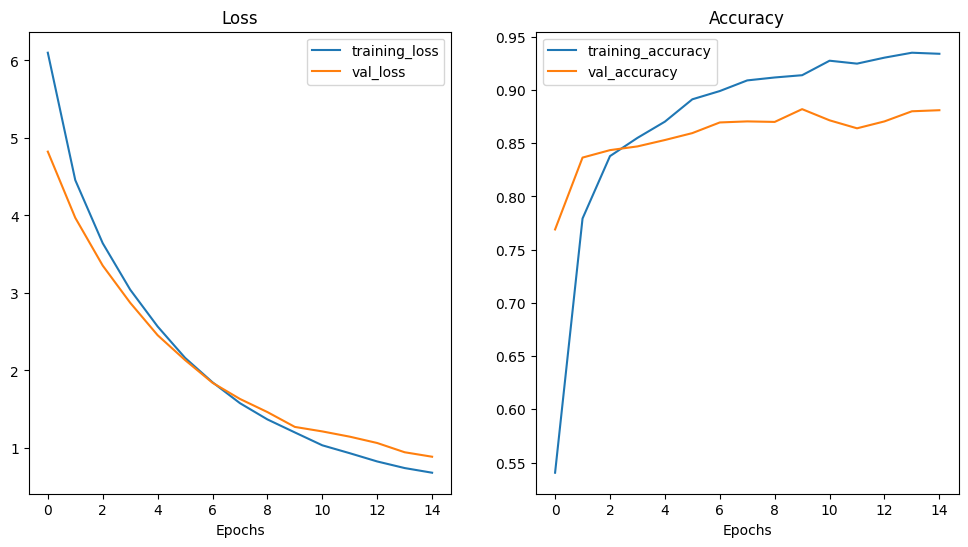

In [19]:
plot_loss_curves(history)

In [20]:
from sklearn.metrics import classification_report

# Evaluate the model on the test set
y_true = np.array([])
y_pred = np.array([])
for x, y in test_data:
    y_true = np.concatenate([y_true, np.argmax(y, axis=-1)], axis=0)
    y_pred = np.concatenate([y_pred, np.argmax(model.predict(x), axis=-1)], axis=0)

# Display classification report
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", report)

1/1 [==============================] - 3s 3s/step
Classification Report:
                    precision    recall  f1-score   support

          Airport       0.90      0.82      0.86        68
         BareLand       0.95      0.95      0.95        62
    BaseballField       0.97      0.90      0.94        42
            Beach       0.98      0.95      0.97        88
           Bridge       0.89      0.97      0.93        64
           Center       0.79      0.85      0.82        53
           Church       0.52      0.95      0.67        56
       Commercial       0.79      0.76      0.77        54
 DenseResidential       0.84      0.90      0.87        84
           Desert       0.97      0.93      0.95        60
         Farmland       0.99      0.97      0.98        74
           Forest       0.98      0.98      0.98        55
       Industrial       0.85      0.85      0.85        66
           Meadow       1.00      0.96      0.98        67
MediumResidential       0.89      0.73  

Class counts: [57 61 39 85 62 46 53 51 80 60]


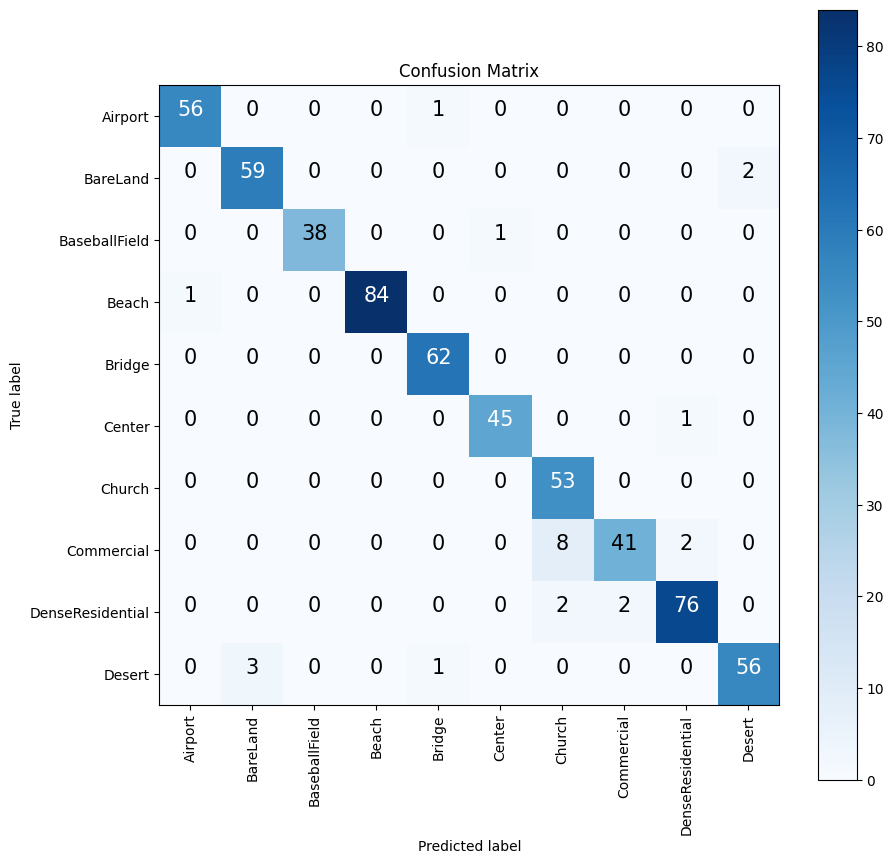

In [21]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False):

    # Create the confusion matrix for the selected classes
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Select only the first 10 classes
    conf_matrix_subset = conf_matrix[:10, :10]

    # Print the sum of instances for each class
    print("Class counts:", np.sum(conf_matrix_subset, axis=1))

    # Normalize the confusion matrix if specified
    if norm:
        conf_matrix_norm = conf_matrix_subset.astype("float") / conf_matrix_subset.sum(axis=1)[:, np.newaxis]
    else:
        conf_matrix_norm = None

    n_classes = conf_matrix_subset.shape[0]

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(conf_matrix_subset, cmap=plt.cm.Blues)  # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes[:n_classes]
    else:
        labels = np.arange(n_classes)

    # Label the axes
    ax.set(
        title="Confusion Matrix",
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_classes),  # create enough axis slots for each class
        yticks=np.arange(n_classes),
        xticklabels=labels,  # axes will be labeled with class names (if they exist) or ints
        yticklabels=labels,
    )

    # Make x-axis labels appear on bottom
    ax.tick_params(axis='x', labelrotation=90)
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Set the threshold for different colors
    threshold = (conf_matrix_subset.max() + conf_matrix_subset.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(conf_matrix_subset.shape[0]), range(conf_matrix_subset.shape[1])):
        if norm:
            plt.text(j, i, f"{conf_matrix_subset[i, j]} ({conf_matrix_norm[i, j]*100:.1f}%)",
                     horizontalalignment="center",
                     color="white" if conf_matrix_subset[i, j] > threshold else "black",
                     size=text_size)
        else:
            plt.text(j, i, f"{conf_matrix_subset[i, j]}",
                     horizontalalignment="center",
                     color="white" if conf_matrix_subset[i, j] > threshold else "black",
                     size=text_size)

# Assuming y_true and y_pred have been calculated
y_true_subset = y_true[y_true < 10]
y_pred_subset = y_pred[y_true < 10]

# Assuming class_names is defined
make_confusion_matrix(y_true_subset, y_pred_subset, classes=class_names[:32])
plt.show()


1/1 [==============================] - 0s 51ms/step


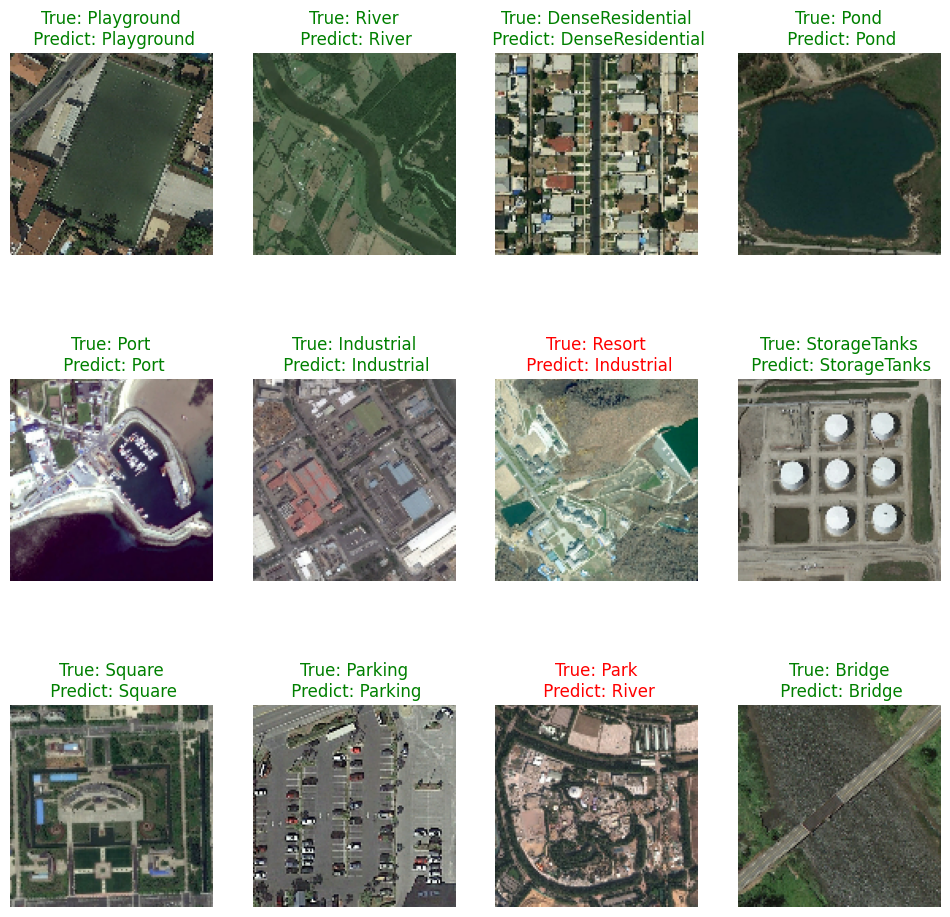

In [22]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12,12))
for image_batch,label_batch in test_data.take(1):
    predictions = model.predict(image_batch)
    predictions = np.argmax(predictions, axis=-1)
    for i in range(0,len(predictions) if len(predictions)<12 else 12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        true_class = class_names[np.argmax(label_batch[i])]
        predict_class = class_names[predictions[i]]
        title = f"""True: {true_class}\n Predict: {predict_class}"""
        plt.title(title, color='g' if true_class==predict_class else 'r')
        plt.axis("off")